# **Analiza danych ankietowych - Sprawozdanie I**

## *Autorzy: Julia Krempińska, Filip Miśkiewicz*

## **Biblioteki**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import altair as alt
import scipy
import math
import random
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import binomtest
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import wald



warnings.filterwarnings("ignore")
%matplotlib inline 

## **Część I**

### **Zadanie 1**

In [2]:
df = pd.read_table('ankieta.csv', sep=';')

In [3]:
df.head() #układ tabeli

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK
0,IT,2,Nie,1,-2,1,M,64
1,IT,2,Nie,0,-2,-2,M,67
2,IT,2,Nie,1,2,2,M,65
3,IT,2,Nie,-1,-2,-2,K,68
4,IT,3,Tak,1,2,-1,K,65


In [4]:
df.isnull().values.any() #brak pustych komórek

False

#### W naszych danych nie występują puste wartości. Teraz zajmiemy się przeanalizowaniem czy wszystkie udzielone odpowiedzi pokrywały się z kluczem.

In [5]:
if all(df["DZIAŁ"].isin(["IT", "HR", "MK", "PD"])):
    print("All DZIAŁ values are fine")

if all(df["STAŻ"].isin([1, 0, 1, 2, 3])):
    print("All STAŻ values are fine")

if all(df["CZY_KIER"].isin(["Tak", "Nie"])):
    print("All CZY_KIER values are fine")

if all(df["PYT_1"].isin([-2, -1, 0, 1, 2])):
    print("All PYT_1 values are fine")

if all(df["PYT_2"].isin([-2, -1, 0, 1, 2])):
    print("All PYT_2 values are fine")

if all(df["PŁEĆ"].isin(["K", "M"])):
    print("All PŁEĆ values are fine")

print(df["WIEK"].dtype)

All DZIAŁ values are fine
All STAŻ values are fine
All CZY_KIER values are fine
All PYT_1 values are fine
All PYT_2 values are fine
All PŁEĆ values are fine
int64


##### Widzimy, że dla każdego pytania udzielone odpowiedzi były zgodne z kluczem.

### **Zadanie 2**

#### Zmienną WIEK_KAT tworzymy według poniższego klucza:
* Jeżeli pracownik ma mniej niż 35 lat - zmienna przyjmuje wartość 0;
* Jeżeli pracownik ma więcej niż 35 lat, ale nie więcej niż 45 - zmienna przyjmuje wartość 1;
* Jeżeli pracownik ma więcej niż 45 lat, ale nie więcej niż 55 - zmienna przyjmuje wartość 2;
* Jeżeli pracownik ma więcej niż 55 lat - zmienna przyjmuje wartość 3.

In [6]:
WIEK_KAT = np.zeros(len(df["WIEK"]))
for i in range(len(df["WIEK"])): #sprawdzanie warunków
    if 35 < df["WIEK"][i] <= 45:
        WIEK_KAT[i] = 1
    if 45 < df["WIEK"][i] <= 55:
        WIEK_KAT[i] = 2
    if df["WIEK"][i] > 55:
        WIEK_KAT[i] = 3
df["WIEK_KAT"] = WIEK_KAT
df.tail() #0 jeśli < 35

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK,WIEK_KAT
195,HR,2,Nie,1,2,2,M,42,1.0
196,HR,2,Nie,1,-1,-1,K,35,0.0
197,HR,2,Nie,-1,-2,-2,K,39,1.0
198,HR,2,Nie,1,2,1,K,48,2.0
199,HR,2,Nie,1,2,2,K,42,1.0


### **Zadanie 3**

#### By przedstawić dane w czytelny sposób, tworzymy tablice liczności.

In [7]:
freq_table_dzial = pd.crosstab(df['DZIAŁ'], 'Liczba') / len(df['DZIAŁ'])
freq_table_staz = pd.crosstab(df['STAŻ'], 'Liczba') / len(df['DZIAŁ'])
freq_table_czy_kier = pd.crosstab(df['CZY_KIER'], 'Liczba') / len(df['DZIAŁ'])
freq_table_plec = pd.crosstab(df['PŁEĆ'], 'Liczba') / len(df['DZIAŁ'])
freq_table_PYT_1 = pd.crosstab(df['PYT_1'], 'Liczba') / len(df['DZIAŁ'])
freq_table_PYT_2 = pd.crosstab(df['PYT_2'], 'Liczba') / len(df['DZIAŁ'])
freq_table_wiek_kat = pd.crosstab(df['WIEK_KAT'], 'Liczba') / len(df['DZIAŁ'])

display(freq_table_dzial)

col_0,Liczba
DZIAŁ,
HR,0.155
IT,0.130
MK,0.225
PD,0.490


#### Widzimy, że największa liczba ankietowanych pracuje w Dziale Produktowym, a najmniejsza w IT.

In [8]:
display(freq_table_staz)

col_0,Liczba
STAŻ,
1,0.205
2,0.700
3,0.095


#### Znaczna większość ankietowanych pracuje między jednym a trzema latami.

In [9]:
display(freq_table_czy_kier)

col_0,Liczba
CZY_KIER,
Nie,0.865
Tak,0.135


#### Tylko 13.5% ankietowanych pełni funkcję kierowniczą.

In [10]:
display(freq_table_plec)

col_0,Liczba
PŁEĆ,
K,0.355
M,0.645


#### Wśród ankietowanych było 64.5% mężczyzn.

In [11]:
display(freq_table_PYT_1)

col_0,Liczba
PYT_1,
-2,0.070
-1,0.085
0,0.200
1,0.500
2,0.145


#### 64.5% ankietowanych zgadza się, że firma zapewnia odpowiednie wsparcie i materiały. Z tym samym stwierdzeniem nie zgadza się 15.5% ankietowanych.

In [12]:
display(freq_table_PYT_2)

col_0,Liczba
PYT_2,
-2,0.37
-1,0.10
1,0.01
2,0.52


#### Niemal połowa ankietowanych (47%) nie jest zadowolona z poziomu szkoleń w firmie.

In [13]:
display(freq_table_wiek_kat)

col_0,Liczba
WIEK_KAT,
0.0,0.130
1.0,0.520
2.0,0.225
3.0,0.125


#### Ponad połowa ankietowanych mieści się w przedziale wiekowym 36-45 lat.

### **Zadanie 4**

#### Innym sposobem przedstawienia naszych danych są wykresy kołowe oraz słupkowe.

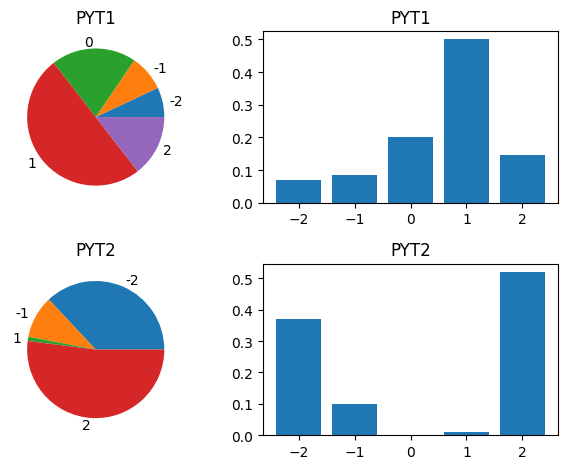

In [14]:
plt.subplot(2,2,1)
plt.pie(freq_table_PYT_1["Liczba"], labels = [-2, -1, 0, 1, 2])
plt.title("PYT1")


plt.subplot(2,2,2)
plt.bar([-2, -1, 0, 1, 2], freq_table_PYT_1["Liczba"])
plt.title("PYT1")


plt.subplot(2,2,3)
plt.pie(freq_table_PYT_2["Liczba"], labels = [-2, -1, 1, 2])
plt.title("PYT2")


plt.subplot(2,2,4)
plt.bar([-2, -1, 1, 2], freq_table_PYT_2["Liczba"])
plt.title("PYT2")


plt.tight_layout()

#### Na wykresach dotyczących pytania 1, widzimy, że liczba negatywnych odpowiedzi (-2,-1) jest niewielka w porównaniu do odpowiedzi pozytywnych i neutralnych (0,1,2).
#### Na wykresach dotyczących pytania 2, widzimy, że odpowiedzi są spolaryzowane i jest porównywalna liczba ankietowanych o całkowicie odmiennych stanowiskach wobec postawionej w pytaniu tezy.

### **Zadanie 5**

#### Tworzymy również tablice wielodzielcze do przedstawienia rozkładu odpowiedzi na pytanie 1 w zależności od działu, stanowiska, płci czy wieku ankietowanych.

In [15]:
df1 = pd.crosstab(df["PYT_1"], df["DZIAŁ"])
df2 = pd.crosstab(df["PYT_1"], df["STAŻ"])
df3 = pd.crosstab(df["PYT_1"], df["CZY_KIER"])
df4 = pd.crosstab(df["PYT_1"], df["PŁEĆ"])
df5 = pd.crosstab(df["PYT_1"], df["WIEK_KAT"])

In [16]:
display(df1)

DZIAŁ,HR,IT,MK,PD
PYT_1,,,,
-2,2,0,3,9
-1,2,2,3,10
0,5,4,14,17
1,19,15,15,51
2,3,5,10,11


#### W każdym z działów odpowiedzi pozytywne przeważają nad negatywnymi.

In [17]:
display(df2)

STAŻ,1,2,3
PYT_1,,,
-2,5,5,4
-1,6,10,1
0,8,26,6
1,19,75,6
2,3,24,2


#### Niezależnie od stażu pracy przeważają odpowiedzi pozytywne i neutralne, choć niewielka liczba ankietowanych ze stażem mniejszym niż 1 rok nie pozwala na wysunięcie daleko idących wniosków wobec tej grupy pracowników.

In [18]:
display(df3)

CZY_KIER,Nie,Tak
PYT_1,,
-2,10,4
-1,14,3
0,34,6
1,88,12
2,27,2


#### Osoby bez stanowiska kierowniczego odpowiadały w większości pozytywnie, natomiast aż 13 z 27 osób ze stanowiskiem kierowniczym udzieliło odpowiedzi negatywnej bądź neutralnej.

In [19]:
display(df4)

PŁEĆ,K,M
PYT_1,,
-2,3,11
-1,7,10
0,14,26
1,36,64
2,11,18


#### Zarówno kobiety i mężczyźni odpowiadali w większości pozytywnie.

In [20]:
display(df5)

WIEK_KAT,0.0,1.0,2.0,3.0
PYT_1,,,,
-2,1,11,2,0
-1,6,7,1,3
0,3,24,5,8
1,13,50,25,12
2,3,12,12,2


#### W każdej kategorii wiekowej najliczniejsza jest grupa pracowników, która udzieliła odpowiedzi "zgadzam się".

### **Zadanie 6**

In [21]:
df6 = pd.crosstab(df["PYT_2"], df["PYT_3"])

display(df6)

PYT_3,-2,-1,1,2
PYT_2,,,,
-2,49,16,5,4
-1,3,6,10,1
1,0,0,2,0
2,0,8,15,81


#### Widzimy, że jest duża zależność między odpowiedziami na pytanie 3 i pytanie 2. Najliczniejsze są grupy, które udzieliły odpowiedzi "całkowicie się nie zgadzam" oraz "całkowicie się zgadzam" na oba z postawionych pytań.

### **Zadanie 7**

#### Na podstawie odpowiedzi na pytanie 2, tworzymy kolumnę "CZY_ZADOW", która informuje czy odpowiedź była pozytywna, czy negatywna.

In [22]:
CZY_ZADOW = np.zeros(len(df["PYT_2"]))
for i in range(len(df["PYT_2"])):
    CZY_ZADOW[i] = np.sign(df["PYT_2"][i]) #pozytywna odpowiedź > 0, negatywna < 0
df["CZY_ZADOW"] = CZY_ZADOW
df.tail()

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK,WIEK_KAT,CZY_ZADOW
195,HR,2,Nie,1,2,2,M,42,1.0,1.0
196,HR,2,Nie,1,-1,-1,K,35,0.0,-1.0
197,HR,2,Nie,-1,-2,-2,K,39,1.0,-1.0
198,HR,2,Nie,1,2,1,K,48,2.0,1.0
199,HR,2,Nie,1,2,2,K,42,1.0,1.0


### **Zadanie 8**

#### Dla wybranych par zmiennych tworzymy wykresy mozaikowe.

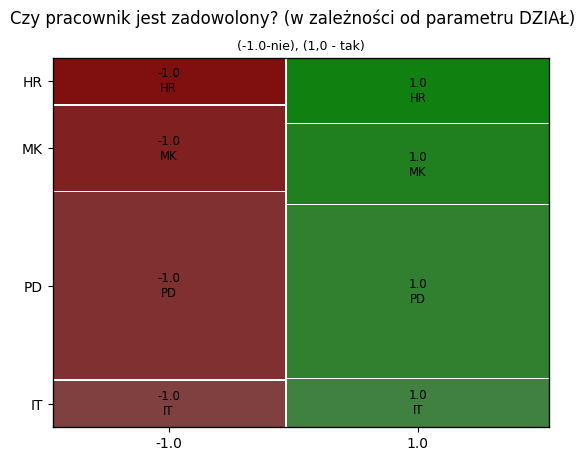

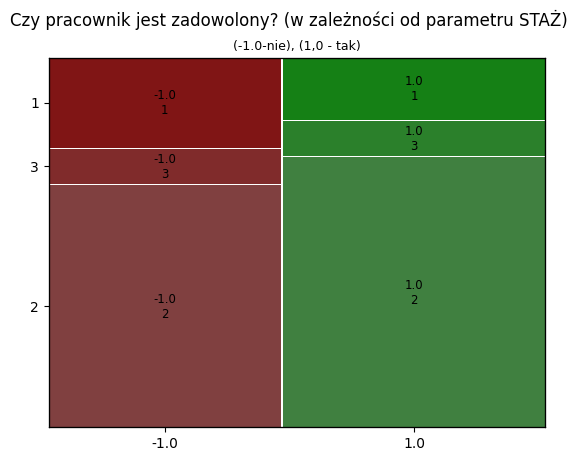

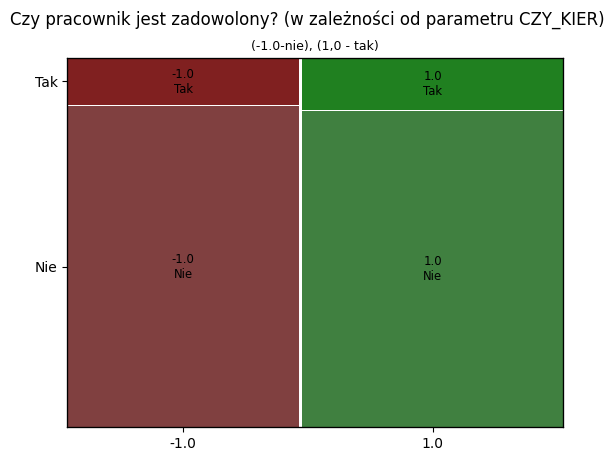

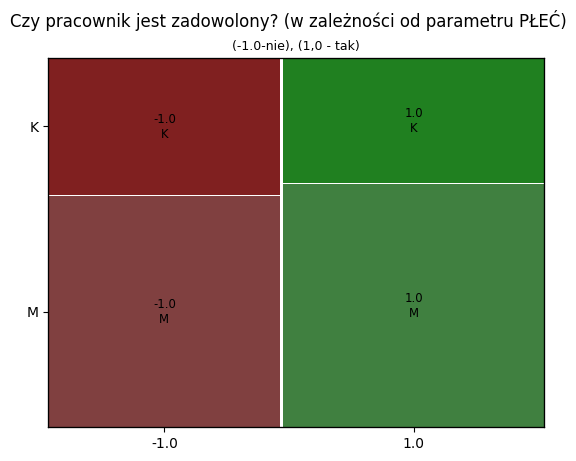

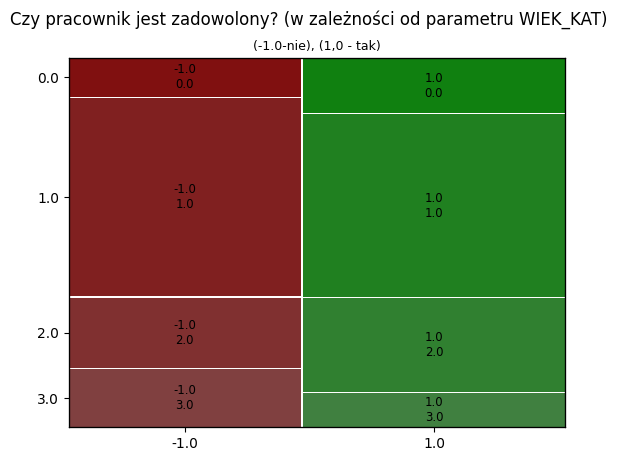

In [23]:
params = ["DZIAŁ", "STAŻ", 'CZY_KIER', 'PŁEĆ', 'WIEK_KAT']
for i in range(len(params)):
    fig = mosaic(df, ['CZY_ZADOW', params[i]], axes_label=True)[0]
    plt.suptitle(f"Czy pracownik jest zadowolony? (w zależności od parametru {params[i]})")
    plt.title("(-1.0-nie), (1,0 - tak)", size=9)
    plt.show()

#### 1) Widzimy, że nieznaczna większość ankietowanych z Działu Produktowego jest niezadowolona.
#### 2) Większość ankietowanych z krótkim stażem pracy nie jest zadowolona.
#### 3) Nie wykazano różnicy w poziomie zadowolenia między osobami na stanowiskach kierowniczych, a tymi bez takiego stanowiska.
#### 4) Pośród ankietowanych, to mężczyźni częściej wykazywali zadowolenie.
#### 5) Najstarsi spośród ankietowanych częściej wykazywali niezadowolenie.

## **Część II**

### **Zadanie 2**

In [24]:
df1 = df[['PYT_1', 'CZY_KIER']]

labels = {
    -2: "Zdecydowanie się nie zgadzam",
    -1: "Nie zgadzam się",
    0: "Neutralnie",
    1: "Zgadzam się",
    2: "Zdecydowanie się zgadzam"
}
df1['PYT_1_label'] = df1['PYT_1'].map(labels)

overall_chart = (
    alt.Chart(df1)
    .mark_bar()
    .encode(
        x=alt.X('PYT_1_label:O', title='Ocena', sort=list(labels.values())),
        y=alt.Y('count()', title='Liczba odpowiedzi'),
        tooltip=['count()']
    )
    .properties(title='Rozkład odpowiedzi w całej grupie')
)

subgroup_chart = (
    alt.Chart(df1)
    .mark_bar()
    .encode(
        x=alt.X('PYT_1_label:O', title='Ocena', sort=list(labels.values())),
        y=alt.Y('count()', title='Liczba odpowiedzi'),
        color='CZY_KIER:N',
        column=alt.Column('CZY_KIER:N', title='Czy kierownik?'),
        tooltip=['count()']
    )
    .properties(title='Rozkład odpowiedzi w podgrupach')
)

alt.hconcat(overall_chart, subgroup_chart)

alt.HConcatChart(...)

### **Zadanie 3**

In [25]:
with_replacement = np.random.choice(df.index, size=int(0.1 * len(df)), replace=True)
sample_with_replacement = df.loc[with_replacement]

duplicates_with = pd.Series(with_replacement).value_counts()
repeated_with = duplicates_with[duplicates_with > 1]

without_replacement = np.random.choice(df.index, size=int(0.1 * len(df)), replace=False)
sample_without_replacement = df.loc[without_replacement]

duplicates_without = pd.Series(without_replacement).value_counts()
repeated_without = duplicates_without[duplicates_without > 1]

display('Ze zwracaniem:', sample_with_replacement)
print('Powtórzenia (ze zwracaniem):', len(repeated_with))

display('Bez zwracania:', sample_without_replacement)
print('Powtórzenia (bez zwracania):', len(repeated_without))


'Ze zwracaniem:'

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK,WIEK_KAT,CZY_ZADOW
8,IT,2,Nie,1,2,2,K,56,3.0,1.0
10,IT,2,Nie,2,-2,-2,K,48,2.0,-1.0
199,HR,2,Nie,1,2,2,K,42,1.0,1.0
127,MK,2,Nie,0,-2,-2,K,45,1.0,-1.0
23,IT,3,Nie,2,2,2,K,52,2.0,1.0
22,IT,2,Nie,-1,-2,-2,K,60,3.0,-1.0
196,HR,2,Nie,1,-1,-1,K,35,0.0,-1.0
18,IT,2,Nie,1,2,-1,K,34,0.0,1.0
107,PD,2,Tak,-2,-2,-2,K,40,1.0,-1.0
101,PD,2,Nie,1,-1,1,K,43,1.0,-1.0


Powtórzenia (ze zwracaniem): 0


'Bez zwracania:'

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK,WIEK_KAT,CZY_ZADOW
60,PD,2,Nie,1,2,2,M,53,2.0,1.0
6,IT,2,Tak,2,2,1,K,57,3.0,1.0
186,HR,2,Tak,2,2,2,M,48,2.0,1.0
191,HR,2,Nie,0,-2,-1,M,64,3.0,-1.0
134,MK,2,Nie,0,-2,-1,K,44,1.0,-1.0
156,MK,2,Nie,1,2,2,M,49,2.0,1.0
159,MK,2,Nie,1,2,2,M,30,0.0,1.0
3,IT,2,Nie,-1,-2,-2,K,68,3.0,-1.0
44,PD,1,Nie,1,2,2,M,36,1.0,1.0
43,PD,2,Tak,-2,-2,-1,M,40,1.0,-1.0


Powtórzenia (bez zwracania): 0


### **Zadanie 4**

#### Gęstość rozkładu dwumianowego opisujemy za pomocą wzoru
#### $$ P(N) = \binom{n}{N}p^N(1-p)^{n-N},$$
#### gdzie $n$ oznacza liczbę prób, $N$ liczbę sukcesów oraz $p$ prawdopodobieńśtwo sukcesu.

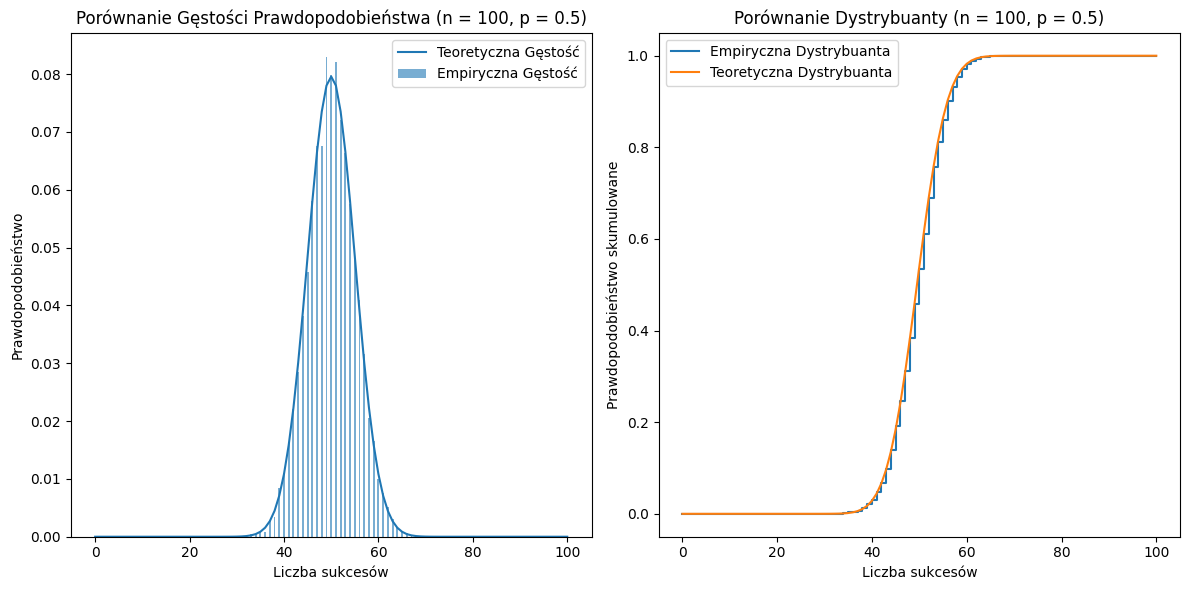

In [26]:
def binomial_coeff(n, k):
    return math.comb(n, k)

def binomial_pdf(n, p, k):
    return binomial_coeff(n, k) * (p ** k) * ((1 - p) ** (n - k))

def empirical_pdf(n, p, M):
    successes_count = [0] * (n + 1)
    
    for _ in range(M):
        successes = binomial_trial(n, p)
        successes_count[successes] += 1
    
    return [count / M for count in successes_count]

def binomial_trial(n, p):
    successes = 0
    for _ in range(n):
        if random.random() < p:
            successes += 1
    return successes

def binomial_cdf(n, p, k):
    return sum(binomial_pdf(n, p, i) for i in range(k + 1))

def empirical_cdf(n, p, M):
    successes_count = [0] * (n + 1)
    
    for _ in range(M):
        successes = binomial_trial(n, p)
        successes_count[successes] += 1
    
    cumulative_count = np.cumsum(successes_count)
    return cumulative_count / M

# Parametry
n = 100  # liczba prób
p = 0.5  # prawdopodobieństwo sukcesu
M = 10000  # liczba prób do symulacji


k_values = list(range(n + 1))
theoretical_pdf = [binomial_pdf(n, p, k) for k in k_values]
theoretical_cdf = [binomial_cdf(n, p, k) for k in k_values]

empirical_pdf_values = empirical_pdf(n, p, M)
empirical_cdf_values = empirical_cdf(n, p, M)



plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(k_values, empirical_pdf_values, width=0.4, alpha=0.6, label="Empiryczna Gęstość")
plt.plot(k_values, theoretical_pdf, label="Teoretyczna Gęstość")
plt.xlabel("Liczba sukcesów")
plt.ylabel("Prawdopodobieństwo")
plt.title(f"Porównanie Gęstości Prawdopodobieństwa (n = {n}, p = {p})")
plt.legend()

plt.subplot(1, 2, 2)
plt.step(k_values, empirical_cdf_values, where="post", label="Empiryczna Dystrybuanta")
plt.plot(k_values, theoretical_cdf, label="Teoretyczna Dystrybuanta")
plt.xlabel("Liczba sukcesów")
plt.ylabel("Prawdopodobieństwo skumulowane")
plt.title(f"Porównanie Dystrybuanty (n = {n}, p = {p})")
plt.legend()

plt.tight_layout()
plt.show()


### **Zadanie 5**

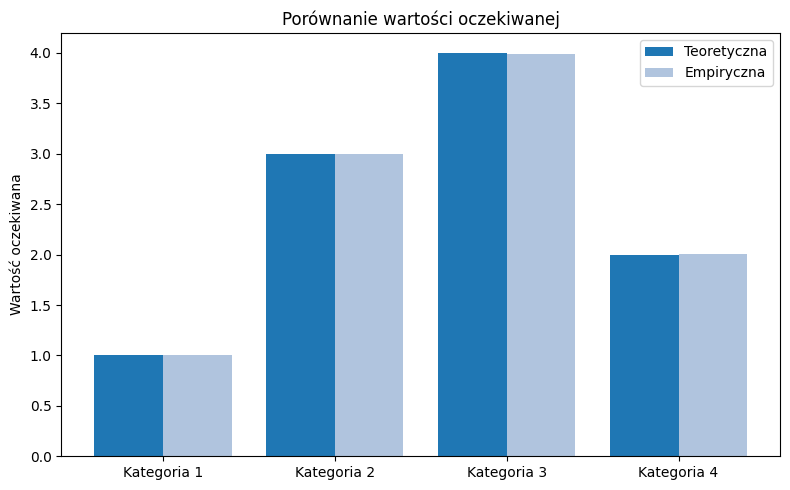

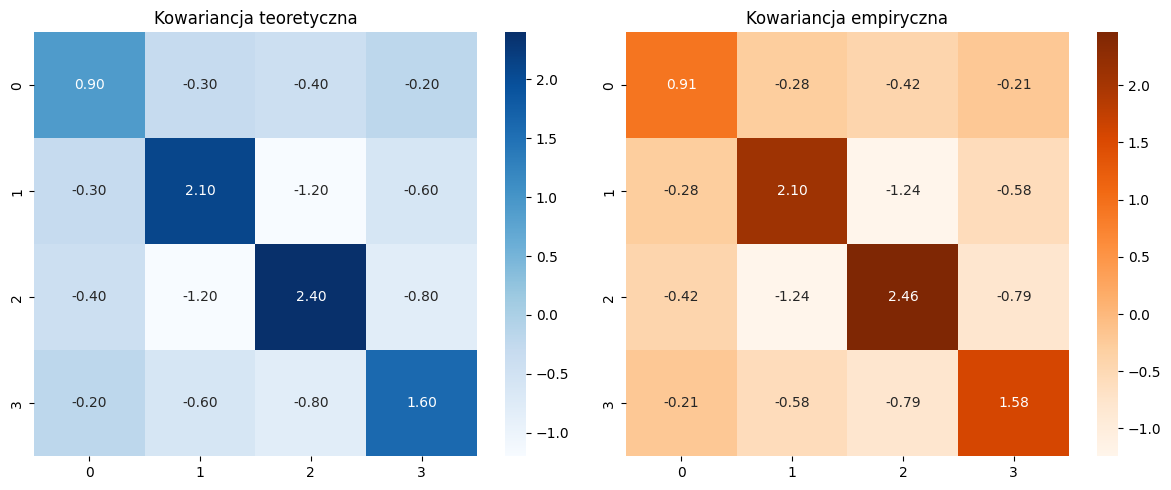

In [27]:
def simulate_multinomial_manual(n, p, num_samples):
    """
    Symuluje próbki z rozkładu wielomianowego bez użycia gotowych funkcji.
    
    Parameters:
        n (int): liczba prób w jednym eksperymencie
        p (list): lista prawdopodobieństw dla każdej kategorii (suma = 1)
        num_samples (int): liczba próbek (eksperymentów)
        
    Returns:
        samples (ndarray): macierz wyników (num_samples x len(p))
    """
    categories = len(p)
    p = np.array(p)
    cumulative_p = np.cumsum(p)
    
    samples = np.zeros((num_samples, categories), dtype=int)
    
    for i in range(num_samples):
        count = np.zeros(categories, dtype=int)
        for _ in range(n):
            r = np.random.rand()
            for j in range(categories):
                if r < cumulative_p[j]:
                    count[j] += 1
                    break
        samples[i] = count
        
    return samples

# Parametry
n = 10
p = [0.1, 0.3, 0.4, 0.2]
num_samples = 10000

samples = simulate_multinomial_manual(n, p, num_samples)

mean_theoretical = n * np.array(p)
cov_theoretical = n * (np.diag(p) - np.outer(p, p))
mean_empirical = np.mean(samples, axis=0)
cov_empirical = np.cov(samples, rowvar=False)

categories = [f"Kategoria {i+1}" for i in range(len(p))]
x = np.arange(len(p))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, mean_theoretical, width=0.4, label='Teoretyczna')
plt.bar(x + 0.2, mean_empirical, color="lightsteelblue", width=0.4, label='Empiryczna')
plt.xticks(x, categories)
plt.ylabel("Wartość oczekiwana")
plt.title("Porównanie wartości oczekiwanej")
plt.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cov_theoretical, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title("Kowariancja teoretyczna")

sns.heatmap(cov_empirical, annot=True, fmt=".2f", cmap="Oranges", ax=axes[1])
axes[1].set_title("Kowariancja empiryczna")

plt.tight_layout()
plt.show()


## **Część III i IV**

### **Zadanie 6**

#### Definiujemy funkcję do wyznaczania realizacji przedziałów ufności Cloppera-Pearsona.

In [28]:
def clopper_pearson(successes, trials, alpha=0.05): #liczba sukcesów, liczba prób, poziom ufności
    beta_ppf = scipy.stats.beta.ppf #punktowa funkcja procentowa zmiennej beta
    low = beta_ppf(alpha / 2, successes, trials - successes + 1) #dolna granica
    high = beta_ppf(1 - alpha / 2, successes + 1, trials - successes) # górna granica
    
    if math.isnan(low): 
        low = 0
    if math.isnan(high):
        high = 1
    
    return [low, high]

### **Zadanie 7**

#### Przed wyznaczeniem realizacji przedziałów ufności, tworzymy kolumnę "CZY_ZADOW_2", która informuje czy ankietowany był zadowolony na podstawie jego odpowiedzi do pytania numer 3.

In [29]:
CZY_ZADOW_2 = np.zeros(len(df["PYT_3"]))
for i in range(len(df["PYT_3"])):
    CZY_ZADOW_2[i] = np.sign(df["PYT_3"][i]) #jeżeli ankietowany jest zadowolony, to jego odpowiedź jest dodatnia
df["CZY_ZADOW_2"] = CZY_ZADOW_2
df.tail()

,DZIAŁ,STAŻ,CZY_KIER,PYT_1,PYT_2,PYT_3,PŁEĆ,WIEK,WIEK_KAT,CZY_ZADOW,CZY_ZADOW_2
195,HR,2,Nie,1,2,2,M,42,1.0,1.0,1.0
196,HR,2,Nie,1,-1,-1,K,35,0.0,-1.0,-1.0
197,HR,2,Nie,-1,-2,-2,K,39,1.0,-1.0,-1.0
198,HR,2,Nie,1,2,1,K,48,2.0,1.0,1.0
199,HR,2,Nie,1,2,2,K,42,1.0,1.0,1.0


#### W analizowanym przypadku liczba prób jest równa liczbie udzielonych odpowiedzi, natomiast za sukces traktujemy każdą pozytywną odpowiedź.

In [30]:
n_1 = len(df["PYT_2"])
n_2 = len(df["PYT_3"])
positive_1 = len(df.query('CZY_ZADOW > 0')) #sumujemy liczbę dodatnich wartości (zadowolonych ankietowanych)
positive_2 = len(df.query('CZY_ZADOW_2 > 0')) #sumujemy liczbę dodatnich wartości (zadowolonych ankietowanych)

In [31]:
confidence_interval_czy_zadow = clopper_pearson(positive_1, n_1)
print(f"For CZY_ZADOW confidence interval is: low: {confidence_interval_czy_zadow[0]}, high: {confidence_interval_czy_zadow[1]}")

confidence_interval_czy_zadow_2 = clopper_pearson(positive_2, n_2)
print(f"For CZY_ZADOW_2 confidence interval is: low: {confidence_interval_czy_zadow_2[0]}, high: {confidence_interval_czy_zadow_2[1]}")

For CZY_ZADOW confidence interval is: low: 0.4583305004114749, high: 0.6007670588028857
For CZY_ZADOW_2 confidence interval is: low: 0.5184215852127789, high: 0.6588693543285324


### **Zadanie 8**

#### Aby generować próbki z rozkładu dwumianowego w Pythonie, możemy użyć biblioteki *NumPy*.

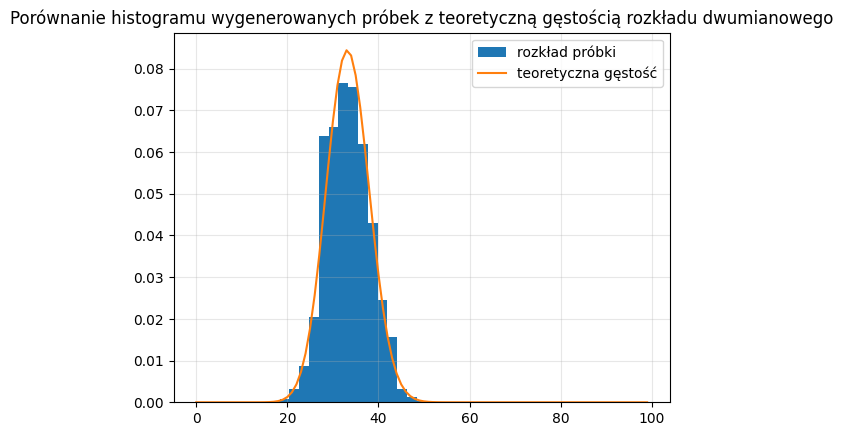

In [32]:
n = 100 #liczba prób
N = np.linspace(0,n, 101, endpoint=True) #0,1,2,...,100
p = 1/3 #prawdopodobieńśtwo sukcesu

theoretical_density = np.zeros(n)
for i in range(n):
    theoretical_density[i] = scipy.special.binom(n, N[i])*p**N[i]*(1-p)**(n-N[i]) #teoretyczna gęstość wyznaczona ze wzoru

samples = np.random.binomial(n, p, 100000) #wygenerowanie dużej liczby próbek

plt.hist(samples, density=True, label = "rozkład próbki", bins=20)
plt.plot(theoretical_density, label = "teoretyczna gęstość")
plt.grid(alpha=0.3)
plt.title("Porównanie histogramu wygenerowanych próbek z teoretyczną gęstością rozkładu dwumianowego")
plt.legend()

#### W celu wyznaczania przedziałów ufności dla parametru $p$ możemy użyć biblioteki *statsmodels*.

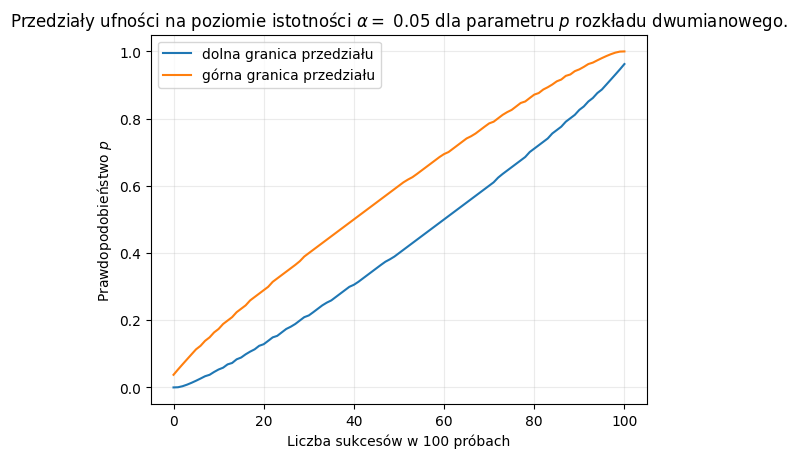

In [33]:
n = 101
confidence_interval = np.zeros(n)
low = np.zeros(n)
high = np.zeros(n)
alpha = 0.05

for i in range(n):
    a = proportion_confint(i, 100, alpha, method = "binom_test") #sukcesy, próby, alpha
    low[i] = a[0] #dolna granica
    high[i] = a[1] #górna granica

plt.plot(N, low, label = "dolna granica przedziału")
plt.plot(N, high, label = "górna granica przedziału")
plt.grid(alpha = 0.25)
plt.title(f"Przedziały ufności na poziomie istotności $\\alpha =$ {alpha} dla parametru $p$ rozkładu dwumianowego.")
plt.xlabel(f"Liczba sukcesów w {n-1} próbach")
plt.ylabel("Prawdopodobieństwo $p$")
plt.legend()

### **Zadanie 9**

In [34]:
n_list = [30, 100, 1000] #wielkości próby
p_list = [0.2, 0.33, 0.5, 0.75] #prawdopodobieństwa sukcesu
methods = ["Clopper-Pearson", "Wald", "Wilson"]
size = 1000
alpha = 0.05

#przygotowanie tablic
probability_of_covering_Clopper = np.zeros((3,4))
probability_of_covering_Wald = np.zeros((3,4))
probability_of_covering_Wilson = np.zeros((3,4))

avg_length_Clopper = np.zeros((3,4))
avg_length_Wald = np.zeros((3,4))
avg_length_Wilson = np.zeros((3,4))

max_length_Clopper = np.zeros((3,4))
max_length_Wald = np.zeros((3,4))
max_length_Wilson = np.zeros((3,4))

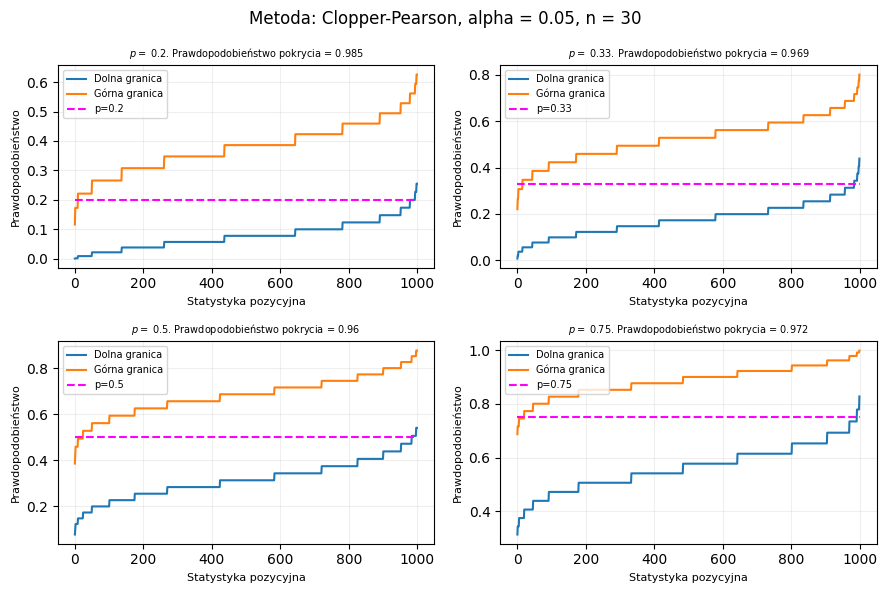

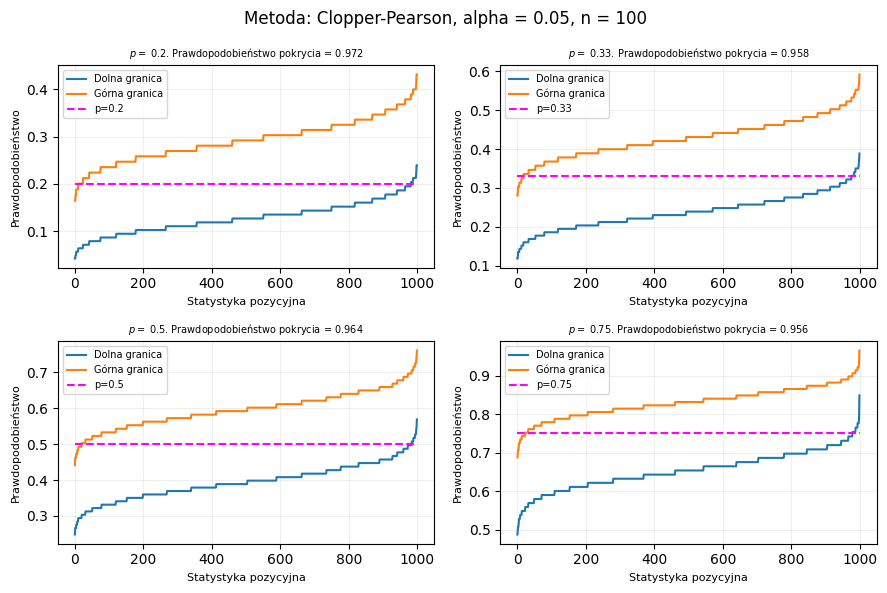

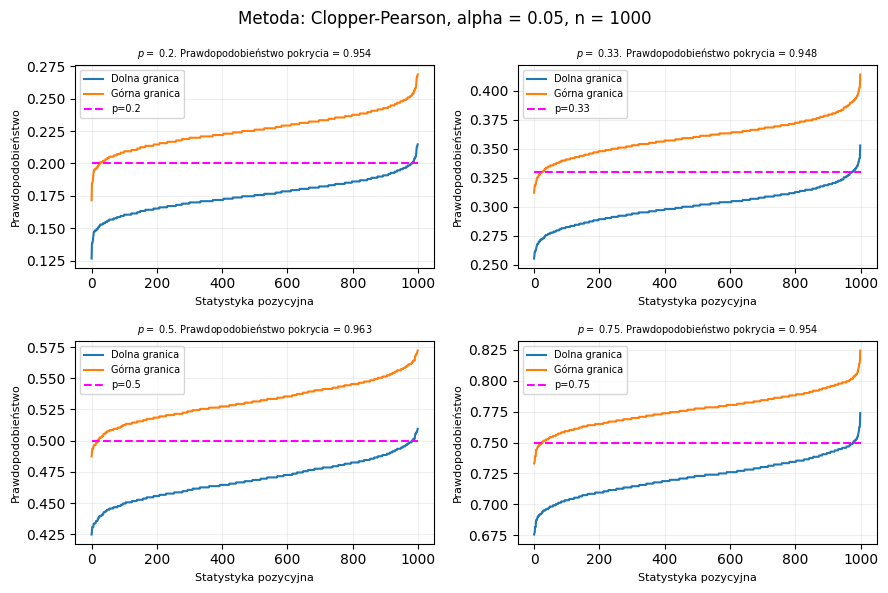

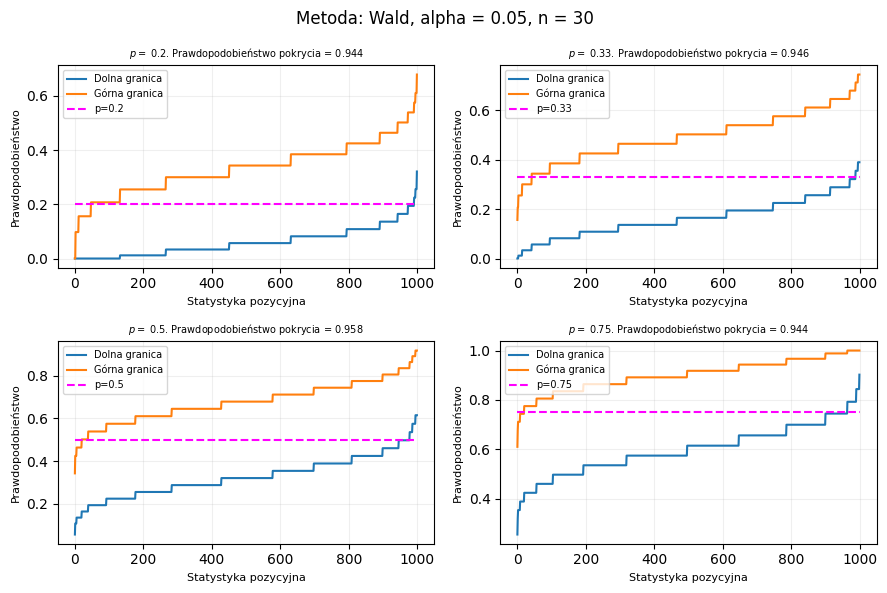

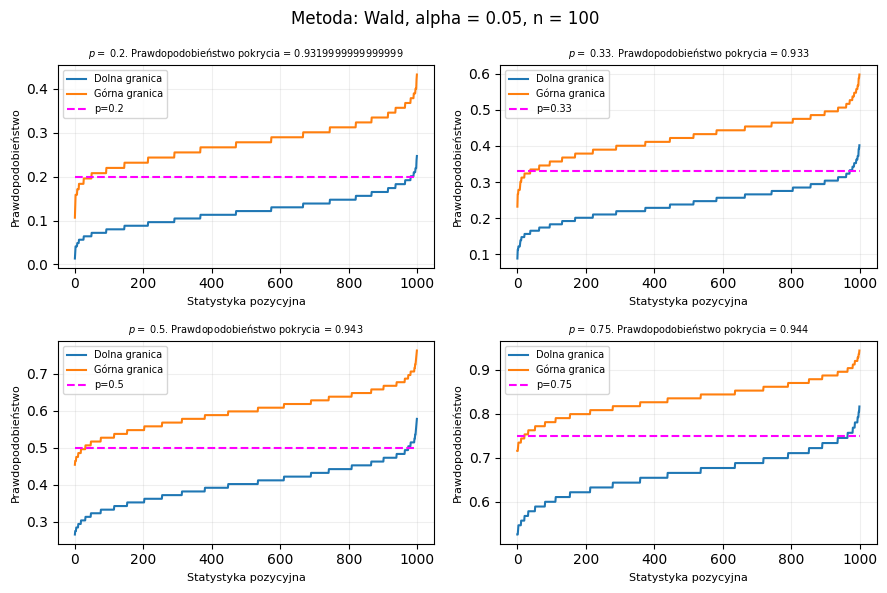

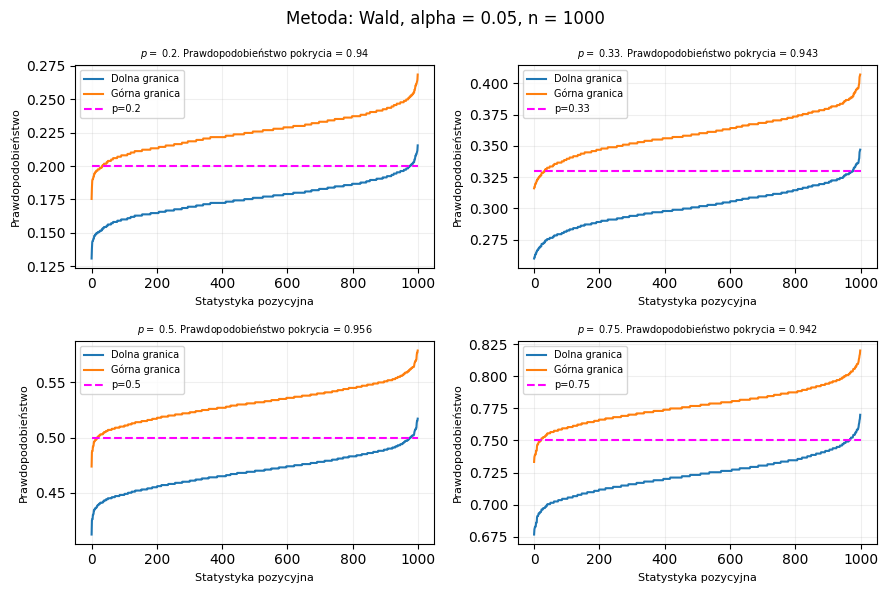

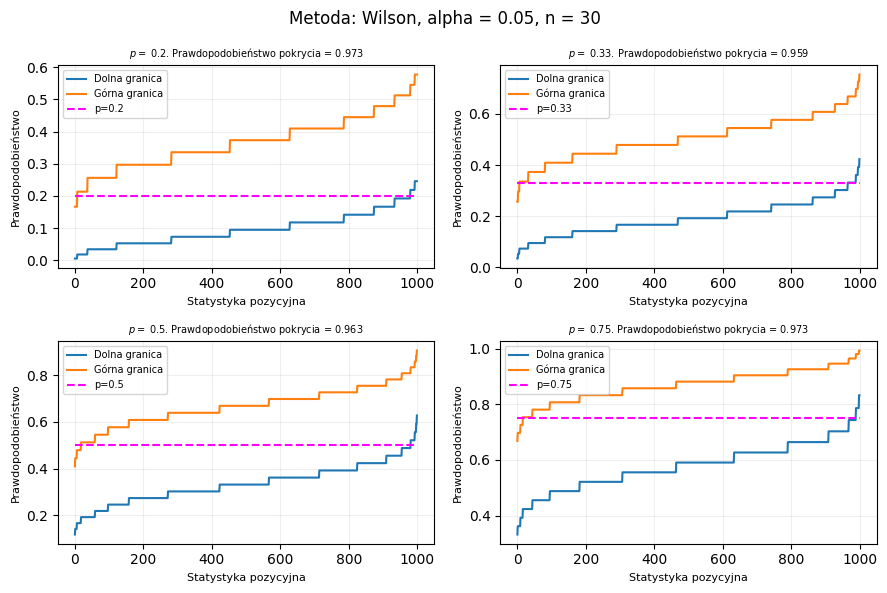

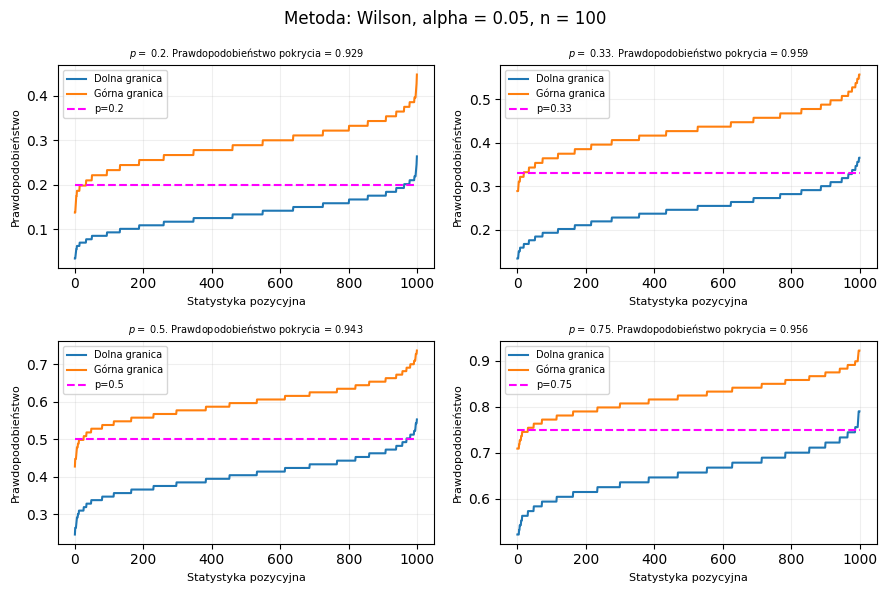

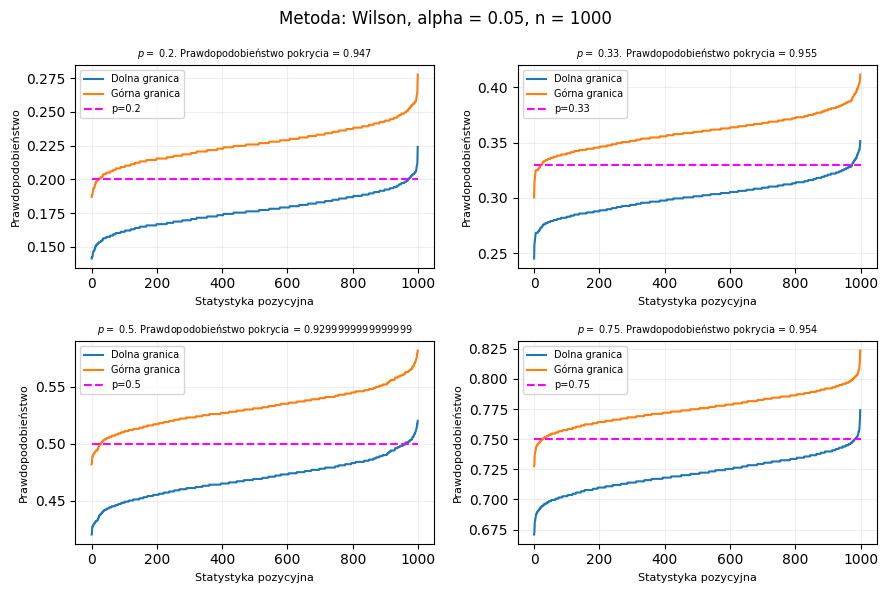

In [35]:
for method in methods:
    for i in range(len(n_list)): #iterujemy po wartościach n
        figure = plt.figure(figsize=(9,6))
        for j in range(len(p_list)): #iterujemy po wartościach p
            data = np.random.binomial(n_list[i], p_list[j], size) #generujemy próbkę z rozkładu dwumianowego
            data = np.sort(data) #sortujemy próbkę w celach wizualizacji na wykresie
            lows = []
            highs = []
            error_counter = 0 #licznik wartości "wypadających" poza przedział ufności
            for k in range(size): #iterujemy po wygenerowanej próbce
                if method == "Clopper-Pearson":
                    result = clopper_pearson(data[k], n_list[i], alpha) #przedział ufności Cloppera-Pearsona
                if method == "Wald":
                    result = sm.stats.proportion_confint(count = data[k], nobs = n_list[i], alpha=alpha, method = "normal") #normal = wald
                if method == "Wilson":
                    result = sm.stats.proportion_confint(count = data[k], nobs = n_list[i], alpha=alpha, method = "wilson") #wilson
                lows.append(result[0]) #dolna granica przedziału
                highs.append(result[1]) #górna granica przedziału
                length = result[1] - result[0]
                if result[0] > p_list[j]: #wartości dolnej granicy większe od wartości p
                    error_counter += 1
                if result[1] < p_list[j]: #wartości górnej granicy mniejsze od wartości p
                    error_counter += 1
                correct = 1 - error_counter/size #prawdopodobieństwo pokrycia
                if method == "Clopper-Pearson":
                    probability_of_covering_Clopper[i][j] = correct
                    avg_length_Clopper[i][j] += length #na razie tylko sumujemy uzyskane długości (*)
                    if length >= max_length_Clopper[i][j]:
                        max_length_Clopper[i][j] = length #najdłuższa zastępuje dotychczasową maksymalną
                if method == "Wald":
                    probability_of_covering_Wald[i][j] = correct
                    avg_length_Wald[i][j] += length #na razie tylko sumujemy uzyskane długości (*)
                    if length >= max_length_Wald[i][j]:
                        max_length_Wald[i][j] = length #najdłuższa zastępuje dotychczasową maksymalną
                if method == "Wilson":
                    probability_of_covering_Wilson[i][j] = correct
                    avg_length_Wilson[i][j] += length #na razie tylko sumujemy uzyskane długości (*)
                    if length >= max_length_Wilson[i][j]:
                        max_length_Wilson[i][j] = length #najdłuższa zastępuje dotychczasową maksymalną
            #________wykres_________
            plt.subplot(2,2,j+1)
            plt.title(f"$p =$ {p_list[j]}. Prawdopodobieństwo pokrycia = {correct}", size = 7)
            plt.grid(alpha=0.2)
            plt.plot(lows, label = "Dolna granica")
            plt.xlabel("Statystyka pozycyjna", fontsize = 8)
            plt.ylabel("Prawdopodobieństwo", fontsize = 8)
            plt.plot(highs, label = "Górna granica")
            plt.hlines(p_list[j], 0, size, color = "magenta", linestyles= "--", label = f"p={p_list[j]}")
            plt.legend(fontsize = 7, loc = "upper left")
        plt.suptitle(f"Metoda: {method}, alpha = {alpha}, n = {n_list[i]}")
        plt.tight_layout()
        plt.show()

avg_length_Clopper = avg_length_Clopper/size #zsumowane wartości w (*) dzielimy przez ich liczbę w celu uzyskania średniej
avg_length_Wald = avg_length_Wald/size #zsumowane wartości w (*) dzielimy przez ich liczbę w celu uzyskania średniej
avg_length_Wilson = avg_length_Wilson/size #zsumowane wartości w (*) dzielimy przez ich liczbę w celu uzyskania średniej

#### **1) Długości przedziałów**

#### a) Clopper - Pearson

In [36]:
rows = ["n = 30", "n = 100", "n = 1000"]
columns = ["p = 0.20", "p = 0.33", "p = 0.50", "p = 0.75"]

max_length_Clopper_df = pd.DataFrame(max_length_Clopper, rows, columns)
print("Maksymalne długości uzyskanych przedziałów:")
display(max_length_Clopper_df)
print("Średnie długości uzyskanych przedziałów:")
avg_length_Clopper_df = pd.DataFrame(avg_length_Clopper, rows, columns)
display(avg_length_Clopper_df)

Maksymalne długości uzyskanych przedziałów:


,p = 0.20,p = 0.33,p = 0.50,p = 0.75
n = 30,0.371119,0.374059,0.374059,0.374059
n = 100,0.191974,0.203320,0.203358,0.200236
n = 1000,0.053962,0.061185,0.062902,0.057467


Średnie długości uzyskanych przedziałów:


,p = 0.20,p = 0.33,p = 0.50,p = 0.75
n = 30,0.299584,0.348958,0.368702,0.323684
n = 100,0.164137,0.190766,0.202396,0.176777
n = 1000,0.050476,0.059175,0.062873,0.054568


#### b) Wald

In [37]:
max_length_Wald_df = pd.DataFrame(max_length_Wald, rows, columns)
print("Maksymalne długości uzyskanych przedziałów:")
display(max_length_Wald_df)
print("Średnie długości uzyskanych przedziałów:")
avg_length_Wald_df = pd.DataFrame(avg_length_Wald, rows, columns)
display(avg_length_Wald_df)

Maksymalne długości uzyskanych przedziałów:


,p = 0.20,p = 0.33,p = 0.50,p = 0.75
n = 30,0.357839,0.357839,0.357839,0.357839
n = 100,0.185690,0.195996,0.195996,0.190268
n = 1000,0.053091,0.060075,0.061980,0.056531


Średnie długości uzyskanych przedziałów:


,p = 0.20,p = 0.33,p = 0.50,p = 0.75
n = 30,0.274189,0.329443,0.351758,0.302021
n = 100,0.155110,0.183473,0.194982,0.168651
n = 1000,0.049597,0.058280,0.061949,0.053627


#### c) Wilson

In [38]:
max_length_Wilson_df = pd.DataFrame(max_length_Wilson, rows, columns)
print("Maksymalne długości uzyskanych przedziałów:")
display(max_length_Wilson_df)
print("Średnie długości uzyskanych przedziałów:")
avg_length_Wilson_df = pd.DataFrame(avg_length_Wilson, rows, columns)
display(avg_length_Wilson_df)

Maksymalne długości uzyskanych przedziałów:


,p = 0.20,p = 0.33,p = 0.50,p = 0.75
n = 30,0.330890,0.336917,0.336917,0.336917
n = 100,0.183813,0.191743,0.192337,0.186926
n = 1000,0.053607,0.060090,0.061861,0.056717


Średnie długości uzyskanych przedziałów:


,p = 0.20,p = 0.33,p = 0.50,p = 0.75
n = 30,0.270966,0.314190,0.332104,0.290830
n = 100,0.154446,0.180538,0.191460,0.166871
n = 1000,0.049538,0.058153,0.061827,0.053620


#### d) Porównanie

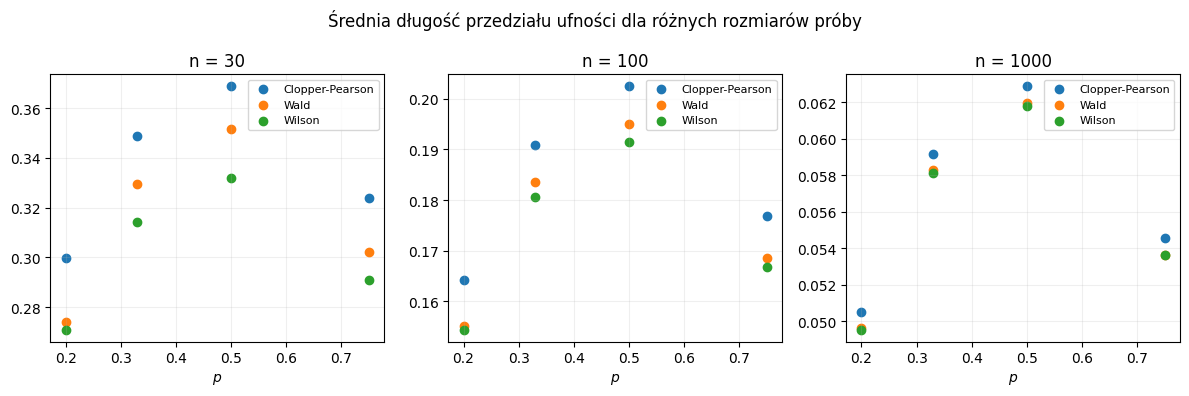

In [39]:
figure = plt.figure(figsize=(12,4))
plt.suptitle("Średnia długość przedziału ufności dla różnych rozmiarów próby")

plt.subplot(1,3,1)
plt.title(f"{rows[0]}")
plt.scatter(p_list, avg_length_Clopper[0], label = "Clopper-Pearson")
plt.scatter(p_list, avg_length_Wald[0], label = "Wald")
plt.scatter(p_list, avg_length_Wilson[0], label = "Wilson")
plt.grid(alpha=0.2)
plt.legend(fontsize = 8)
plt.xlabel("$p$")

plt.subplot(1,3,2)
plt.title(f"{rows[1]}")
plt.scatter(p_list, avg_length_Clopper[1], label = "Clopper-Pearson")
plt.scatter(p_list, avg_length_Wald[1], label = "Wald")
plt.scatter(p_list, avg_length_Wilson[1], label = "Wilson")
plt.grid(alpha=0.2)
plt.legend(fontsize = 8)
plt.xlabel("$p$")

plt.subplot(1,3,3)
plt.title(f"{rows[2]}")
plt.scatter(p_list, avg_length_Clopper[2], label = "Clopper-Pearson")
plt.scatter(p_list, avg_length_Wald[2], label = "Wald")
plt.scatter(p_list, avg_length_Wilson[2], label = "Wilson")
plt.grid(alpha=0.2)
plt.legend(fontsize = 8)
plt.xlabel("$p$")

plt.tight_layout()

#### Na wykresach widzimy, że metoda Cloppera-Pearsona tworzy średnio najdłuższe przedziały, zatem ze względu na otrzymywaną długość przedziałów preferowane powinny być metoda Walda i metoda Wilsona, które wypadły porównywalnie do siebie i lepiej od metody Cloppera - Pearsona. Różnice między nimi szczególnie widać dla niewielkiej próby, gdzie najlepiej radzi sobie metoda Wilsona. Przy użyciu każdej z metod, najkrótsze średnie przedziały są dla próby o największym rozmiarze.

#### **2) Prawdopodobieńśtwo pokrycia**

#### a) Clopper - Pearson

In [40]:
probability_of_covering_Clopper_df = pd.DataFrame(probability_of_covering_Clopper, rows, columns)
print("Prawdopodobieństwo pokrycia:")
display(probability_of_covering_Clopper_df)

Prawdopodobieństwo pokrycia:


,p = 0.20,p = 0.33,p = 0.50,p = 0.75
n = 30,0.985,0.969,0.960,0.972
n = 100,0.972,0.958,0.964,0.956
n = 1000,0.954,0.948,0.963,0.954


#### b) Wald

In [41]:
probability_of_covering_Wald_df = pd.DataFrame(probability_of_covering_Wald, rows, columns)
print("Prawdopodobieństwo pokrycia:")
display(probability_of_covering_Wald_df)

Prawdopodobieństwo pokrycia:


,p = 0.20,p = 0.33,p = 0.50,p = 0.75
n = 30,0.944,0.946,0.958,0.944
n = 100,0.932,0.933,0.943,0.944
n = 1000,0.940,0.943,0.956,0.942


#### c) Wilson

In [42]:
probability_of_covering_Wilson_df = pd.DataFrame(probability_of_covering_Wilson, rows, columns)
print("Prawdopodobieństwo pokrycia:")
display(probability_of_covering_Wilson_df)

Prawdopodobieństwo pokrycia:


,p = 0.20,p = 0.33,p = 0.50,p = 0.75
n = 30,0.973,0.959,0.963,0.973
n = 100,0.929,0.959,0.943,0.956
n = 1000,0.947,0.955,0.930,0.954


#### d) Porównanie

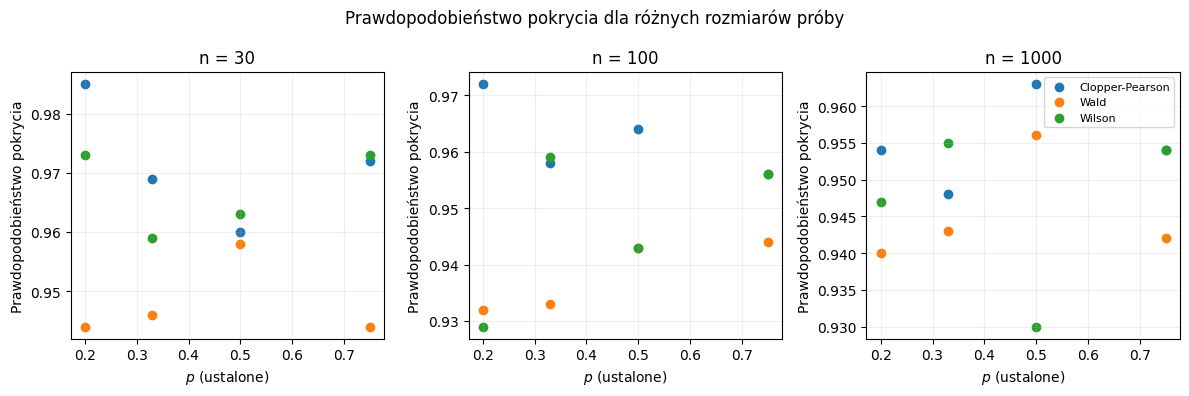

In [43]:
figure = plt.figure(figsize=(12,4))
plt.suptitle("Prawdopodobieństwo pokrycia dla różnych rozmiarów próby")

plt.subplot(1,3,1)
plt.title(f"{rows[0]}")
plt.scatter(p_list, probability_of_covering_Clopper[0], label = "Clopper-Pearson")
plt.scatter(p_list, probability_of_covering_Wald[0], label = "Wald")
plt.scatter(p_list, probability_of_covering_Wilson[0], label = "Wilson")
plt.grid(alpha=0.2)
plt.xlabel("$p$ (ustalone)")
plt.ylabel("Prawdopodobieństwo pokrycia")

plt.subplot(1,3,2)
plt.title(f"{rows[1]}")
plt.scatter(p_list, probability_of_covering_Clopper[1], label = "Clopper-Pearson")
plt.scatter(p_list, probability_of_covering_Wald[1], label = "Wald")
plt.scatter(p_list, probability_of_covering_Wilson[1], label = "Wilson")
plt.grid(alpha=0.2)
plt.xlabel("$p$ (ustalone)")
plt.ylabel("Prawdopodobieństwo pokrycia")

plt.subplot(1,3,3)
plt.title(f"{rows[2]}")
plt.scatter(p_list, probability_of_covering_Clopper[2], label = "Clopper-Pearson")
plt.scatter(p_list, probability_of_covering_Wald[2], label = "Wald")
plt.scatter(p_list, probability_of_covering_Wilson[2], label = "Wilson")
plt.grid(alpha=0.2)
plt.legend(fontsize = 8)
plt.xlabel("$p$ (ustalone)")
plt.ylabel("Prawdopodobieństwo pokrycia")

plt.tight_layout()

#### Widzimy, że nie ma jednoznacznie najlepszej metody ze względu na prawdopodobieństwo pokrycia przy ustalonych wielkościach próby. Dla niewielkiej próby największym prawdopodobieństwem pokrycia wykazywała się metoda Cloppera - Pearsona, co może wiązać się z największą długością przedziałów. Ponieważ przedziały Cloppera - Pearsona są "ekstremalnie konserwatywne", istnieje wysokie ryzyko pokrycia nieznanej wartości. 
#### Metoda Wilsona cechuje się często nie mniejszym prawdopodobieństwem pokrycia od Cloppera - Pearsona, więc to jej należałoby użyć ze względu na najmniejsze długości przedziałów.

## **Część V**

### **Zadanie 10**

In [44]:
result = binomtest(3, n=15, p=0.1, alternative='greater')
display(result.pvalue)

0.18406106910639122

In [45]:
count = np.array([5, 12])
nobs = np.array([83, 99])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

0.159


### **Zadanie 11**

#### 1. Prawdopodobieństwo, że w firmie pracuje kobieta wynosi 0.5.

In [46]:
def check_p_value(p_value):
    if p_value < 0.05:
        print('Hipoteza zerowa może zostać odrzucona')
    else:
        print('Hipoteza zerowa nie może zostać odrzucona')

In [47]:
k = len(df[df['PŁEĆ'] == 'K'])
n = len(df)
p = 0.5
result = binomtest(k, n, p, alternative='two-sided')
p_value = result.pvalue
print(p_value)
check_p_value(p_value)

4.97297347921355e-05
Hipoteza zerowa może zostać odrzucona


In [48]:
stat, pval = proportions_ztest(k, n, p, alternative='two-sided')
print(pval)
check_p_value(pval)

1.8243011136745864e-05
Hipoteza zerowa może zostać odrzucona


#### 2. Prawdopodobieństwo, że pracownik uważa szkolenia za przystosowane do swoich potrzeb w pierwszym badanym okresie jest większe bądź równe 0.7.

In [49]:
k = len(df[(df['PYT_2'] == 1) | (df['PYT_2'] == 2)])
n = len(df)
p = 0.7
result = binomtest(k, n, p, alternative='less')
p_value = result.pvalue
print(p_value)
check_p_value(p_value)

3.212876740960112e-07
Hipoteza zerowa może zostać odrzucona


In [50]:
stat, pval = proportions_ztest(k, n, p, alternative='smaller')
print(pval)
check_p_value(pval)

7.286468776023958e-07
Hipoteza zerowa może zostać odrzucona


#### 3. Prawdopodobieństwo, że kobieta pracuje na stanowisku kierowniczym jest równe prawdopodobieństwu, że mężczyzna pracuje na stanowisku kierowniczym.

In [51]:
k1 = len(df[(df['CZY_KIER'] == 'Tak') & (df['PŁEĆ'] == 'M')])
n1 = len(df[df['PŁEĆ'] == 'M'])
p = k1/n1
k = len(df[(df['CZY_KIER'] == 'Tak') & (df['PŁEĆ'] == 'K')])
n = len(df[df['PŁEĆ'] == 'K'])
result = binomtest(k, n, p, alternative='two-sided')
p_value = result.pvalue
print(p_value)
check_p_value(p_value)

0.5040620681066837
Hipoteza zerowa nie może zostać odrzucona


In [52]:
stat, pval = proportions_ztest(k, n, p, alternative='two-sided')
print(pval)
check_p_value(pval)

0.35635965611973397
Hipoteza zerowa nie może zostać odrzucona


#### 4. Prawdopodobieństwo, że kobieta uważa szkolenia za przystosowane do swoich potrzeb w pierwszym badanym okresie jest równe prawdopodobieństwu, że mężczyzna uważa szkolenia za przystosowane do swoich potrzeb w pierwszym badanym okresie.

In [53]:
k1 = len(df[(df['PYT_2'] <= 1) & (df['PŁEĆ'] == 'M')])
n1 = len(df[df['PŁEĆ'] == 'M'])
p = k1/n1
k = len(df[(df['PYT_2'] <= 1) & (df['PŁEĆ'] == 'K')])
n = len(df[df['PŁEĆ'] == 'K'])
result = binomtest(k, n, p, alternative='two-sided')
p_value = result.pvalue
print(p_value)
check_p_value(p_value)

0.47862248077440184
Hipoteza zerowa nie może zostać odrzucona


In [54]:
stat, pval = proportions_ztest(k, n, p, alternative='two-sided')
print(pval)
check_p_value(pval)

0.4798031720910073
Hipoteza zerowa nie może zostać odrzucona


#### 5. Prawdopodobieństwo, że kobieta pracuje w dziale zasobów ludzkich jest większe lub równe prawdopodobieństwu, że mężczyzna pracuje w dziale zasobów ludzkich.

In [55]:
k1 = len(df[(df['DZIAŁ'] == 'HR') & (df['PŁEĆ'] == 'M')])
n1 = len(df[df['PŁEĆ'] == 'M'])
p = k1/n1
k = len(df[(df['DZIAŁ'] == 'HR') & (df['PŁEĆ'] == 'K')])
n = len(df[df['PŁEĆ'] == 'K'])
result = binomtest(k, n, p, alternative='less')
p_value = result.pvalue
print(p_value)
check_p_value(p_value)

0.0003456683038890572
Hipoteza zerowa może zostać odrzucona


In [56]:
stat, pval = proportions_ztest(k, n, p, alternative='smaller')
print(pval)
check_p_value(pval)

1.135483190810861e-08
Hipoteza zerowa może zostać odrzucona


### **Zadanie 12**

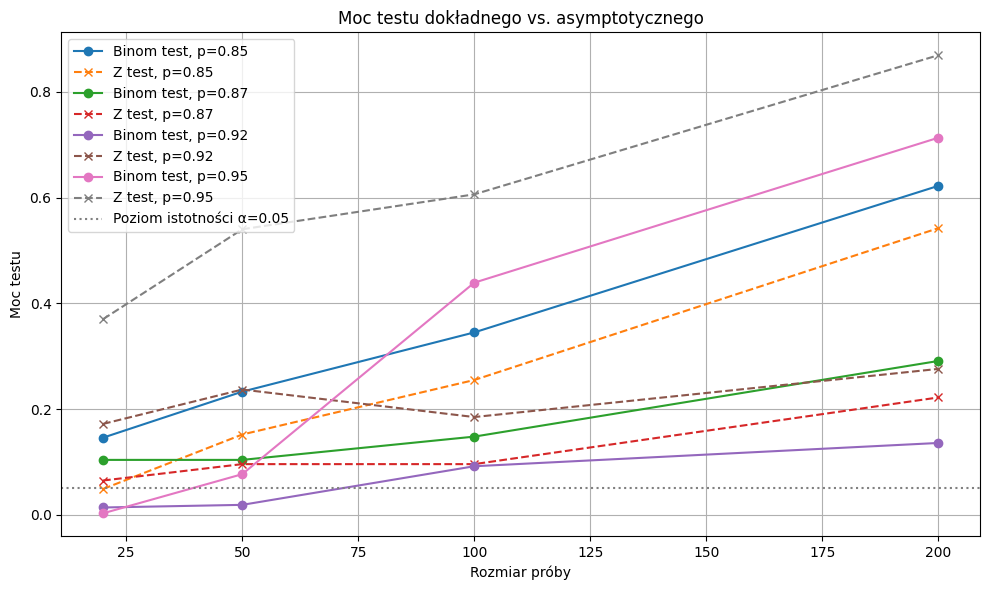

In [57]:
alpha = 0.05
p_null = 0.9
alternative_ps = [0.85, 0.87, 0.92, 0.95]
sample_sizes = [20, 50, 100, 200]
n_simulations = 1000

results = []

for p_alt in alternative_ps:
    for n in sample_sizes:
        rejections_binom = 0
        rejections_z = 0

        for _ in range(n_simulations):
            sample = np.random.binomial(n, p_alt)

            test_binom = binomtest(sample, n, p=p_null, alternative='two-sided')
            if test_binom.pvalue < alpha:
                rejections_binom += 1

            stat, pval = proportions_ztest(sample, n, value=p_null, alternative='two-sided')
            if pval < alpha:
                rejections_z += 1

        power_binom = rejections_binom / n_simulations
        power_z = rejections_z / n_simulations
        results.append((p_alt, n, power_binom, power_z))

df = pd.DataFrame(results, columns=['p_alt', 'sample_size', 'power_binom', 'power_z'])

fig, ax = plt.subplots(figsize=(10, 6))

for p in alternative_ps:
    subset = df[df['p_alt'] == p]
    ax.plot(subset['sample_size'], subset['power_binom'], marker='o', label=f'Binom test, p={p}')
    ax.plot(subset['sample_size'], subset['power_z'], marker='x', linestyle='--', label=f'Z test, p={p}')

ax.set_title('Moc testu dokładnego vs. asymptotycznego')
ax.set_xlabel('Rozmiar próby')
ax.set_ylabel('Moc testu')
ax.axhline(0.05, color='gray', linestyle=':', label='Poziom istotności α=0.05')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

##### Wnioski

1. Moc testu rośnie wraz z rozmiarem próby
Zarówno dla testów dokładnych, jak i asymptotycznych, im większy rozmiar próby, tym większa moc testu.
Szczególnie widoczne dla wartości p=0.95, gdzie moc testu Z i testu dokładnego wzrasta do ponad 0.6 i 0.9.

2. Test Z zazwyczaj ma większą moc dla większych wartości p (np. p=0.95)
Dla p=0.95, Z test znacznie szybciej osiąga wysoką moc niż Binom test.
Sugeruje to, że test Z może być bardziej czuły przy większych efektach (większe różnice od hipotezy zerowej).

3. Test dokładny (Binom) może być bardziej konserwatywny dla małych p
Dla p=0.85 i p=0.87 test Binom ma większą moc niż test Z.
Szczególnie dla małych prób (np. 25, 50), test Binom wypada lepiej lub porównywalnie.

4. Dla niskich wartości p i małych prób test Z może mieć zawyżoną moc
Widać, że test Z dla p=0.92 przy próbie 25 ma relatywnie wysoką moc (~0.2), a potem maleje.
Może to wskazywać na niestabilność oszacowania mocy przy małych próbach – test Z nie jest zalecany dla bardzo małych próbek.

5. Linia przerywana – poziom istotności (α=0.05)
Przypomina, że moc testu powinna być znacznie większa niż poziom istotności, aby test był użyteczny.
Gdy linie znajdują się poniżej tej wartości, oznacza to praktycznie brak mocy (duża szansa na błąd II rodzaju – nie wykrycie efektu, który istnieje).